<a href="https://colab.research.google.com/github/mingd00/Face-Recognition/blob/main/Notebooks/EfficientNet(with_FER).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# EfficientNet 모델을 활용한 FER 데이터 학습



### 0. 라이브러리 호출

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import zoom
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import model_from_json
from tensorflow.keras.models import load_model
from tensorflow.keras.applications.efficientnet import preprocess_input, decode_predictions
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import to_categorical
import cv2
import time

### 1. FER 데이터 로드 및 준비


In [2]:
def preprocess(data_path):
    data = pd.read_csv(data_path)

    # 픽셀 데이터 정규화 및 3채널로 확장
    pixels = data['pixels'].str.split(" ").tolist()  # 픽셀 데이터를 리스트로 변환
    pixels = np.array(pixels, dtype='float32') / 255.0  # 정규화
    pixels = pixels.reshape(-1, 48, 48, 1)  # 48x48 그레이스케일 이미지 형태로 변환
    pixels = np.repeat(pixels, 3, axis=-1)  # 그레이스케일 이미지를 3채널로 확장 (EfficientNet 입력 요구사항)

    # 레이블 원-핫 인코딩
    labels = to_categorical(data['emotion'], num_classes=7)

    # 학습/검증 데이터 분리
    X_train, X_val, y_train, y_val = train_test_split(pixels, labels, test_size=0.2, random_state=42)
    return X_train, X_val, y_train, y_val

X_train, X_val, y_train, y_val = preprocess("fer2013.csv")
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((28709, 48, 48, 3), (7178, 48, 48, 3), (28709, 7), (7178, 7))

### 2. 모델 로드

**- 표정 분류 모델**

In [3]:
# 얼굴 인식 함수
def detect_face(frame):
    cascPath = '/content/haarcascade_frontalface_default.xml'
    faceCascade = cv2.CascadeClassifier(cascPath)

    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    detected_faces = faceCascade.detectMultiScale(
        gray,
        scaleFactor=1.1,
        minNeighbors=6,
        minSize=(48, 48),  # 얼굴 크기
        flags=cv2.CASCADE_SCALE_IMAGE
    )

    if len(detected_faces) > 0:
        return gray, detected_faces[0]  # 첫 번째 얼굴만 처리
    else:
        return gray, None  # 얼굴이 탐지되지 않으면 None 반환

In [4]:
# 얼굴 특징 추출 함수
def extract_face_features(gray, detected_face, offset_coefficients=(0.075, 0.05), shape_x=48, shape_y=48):
    if detected_face is None:
        return None  # 얼굴이 없으면 None 반환

    x, y, w, h = detected_face

    horizontal_offset = int(np.floor(offset_coefficients[0] * w))
    vertical_offset = int(np.floor(offset_coefficients[1] * h))

    # 추출할 얼굴 영역 설정
    extracted_face = gray[
        y + vertical_offset : y + h,
        x + horizontal_offset : x - horizontal_offset + w
    ]

    # 추출된 얼굴 이미지를 줌 조정 (설정된 크기로 스케일 변경)
    new_extracted_face = zoom(
        extracted_face,
        (shape_x / extracted_face.shape[0], shape_y / extracted_face.shape[1])  # 목표 크기로 조정
    )

    # 데이터를 float32 형식으로 변환
    new_extracted_face = new_extracted_face.astype(np.float32)

    # 이미지를 정규화 (최대값으로 나누어 0~1 사이 값으로 변환)
    new_extracted_face /= float(new_extracted_face.max())

    # 정규화된 얼굴 이미지를 반환
    return new_extracted_face

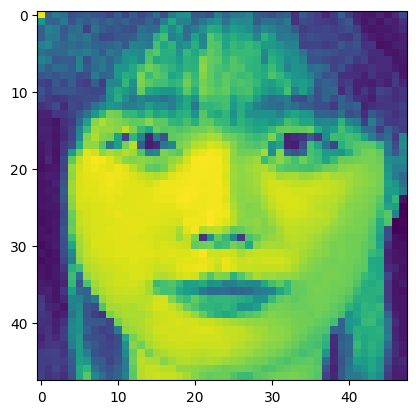

In [5]:
img = cv2.imread("img.jpg")
gray, detected_face = detect_face(img)

if detected_face is not None:
    extracted_face = extract_face_features(gray, detected_face)
    plt.imshow(extracted_face)
else:
    print("No face detected in the image.")

**- 얼굴 인식 모델**

- 모델 생성 및 수정: 사전 학습된 가중치는 고정하고 새로운 출력 레이어만 학습

In [63]:
# EfficientNetB0 로드 (사전 학습된 ImageNet 가중치 사용)
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(48, 48, 3))

def create_model(base_model):
    # 모델 수정 (FER 데이터셋에 맞게 출력 레이어 조정)
    x = base_model.output
    x = GlobalAveragePooling2D()(x)  # 공간 차원을 평균화하여 벡터로 변환
    x = Dense(128, activation='relu')(x)  # 추가 Fully Connected Layer
    predictions = Dense(7, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=predictions)

    return model

model = create_model(base_model)
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4             │ (None, 48, 48, 3)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_8 (Rescaling)   │ (None, 48, 48, 3)      │              0 │ input_layer_4[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ normalization_4           │ (None, 48, 48, 3)      │              7 │ rescaling_8[0][0]      │
│ (Normalization)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_9 (Rescaling)   │ (None, 48, 48, 3)      │              0 │ normalization_4[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv_pad             │ (None, 49, 49, 3)      │              0 │ rescaling_9[0][0]      │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv (Conv2D)        │ (None, 24, 24, 32)     │            864 │ stem_conv_pad[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn                   │ (None, 24, 24, 32)     │            128 │ stem_conv[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_activation           │ (None, 24, 24, 32)     │              0 │ stem_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_dwconv            │ (None, 24, 24, 32)     │            288 │ stem_activation[0][0]  │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_bn                │ (None, 24, 24, 32)     │            128 │ block1a_dwconv[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_activation        │ (None, 24, 24, 32)     │              0 │ block1a_bn[0][0]       │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_squeeze        │ (None, 32)             │              0 │ block1a_activation[0]… │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reshape        │ (None, 1, 1, 32)       │              0 │ block1a_se_squeeze[0]… │
│ (Reshape)                 │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reduce         │ (None, 1, 1, 8)        │            264 │ block1a_se_reshape[0]… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 4,214,442 (16.08 MB)

 Trainable params: 4,172,419 (15.92 MB)

 Non-trainable params: 42,023 (164.16 KB)

### 3. 표정 분류 모델 학습

- 첫 번째 학습: 사전 가중치 고정

In [33]:
def train_model(model, X_train, y_train, X_val, y_val, learning_rate=0.001, batch_size=32, epochs=10):
    # 사전 학습된 가중치 잠금 (Feature Extraction)
    for layer in model.layers:
        layer.trainable = False  # EfficientNet 가중치 고정

    # 모델 컴파일
    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    # 데이터 증강
    datagen = ImageDataGenerator(
        rotation_range=10,
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip=True
    )
    train_generator = datagen.flow(X_train, y_train, batch_size=batch_size)
    val_generator = ImageDataGenerator().flow(X_val, y_val, batch_size=batch_size)

    # 모델 학습
    history = model.fit(
        train_generator,
        validation_data=val_generator,
        epochs=epochs,
        steps_per_epoch=len(X_train) // batch_size,
        validation_steps=len(X_val) // batch_size
    )
    return history

In [34]:
# Feature Extraction 학습
train_history = train_model(model, X_train, y_train, X_val, y_val)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/trainer.py:75: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")
/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


897/897 ━━━━━━━━━━━━━━━━━━━━ 58s 53ms/step - accuracy: 0.2180 - loss: 1.9797 - val_accuracy: 0.2458 - val_loss: 1.9790
Epoch 2/10
  1/897 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - accuracy: 0.2500 - loss: 1.9555

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


897/897 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.2500 - loss: 1.9555 - val_accuracy: 0.3000 - val_loss: 1.8930
Epoch 3/10
897/897 ━━━━━━━━━━━━━━━━━━━━ 60s 38ms/step - accuracy: 0.2249 - loss: 1.9768 - val_accuracy: 0.2461 - val_loss: 1.9789
Epoch 4/10
897/897 ━━━━━━━━━━━━━━━━━━━━ 0s 26us/step - accuracy: 0.2188 - loss: 2.0298 - val_accuracy: 0.1000 - val_loss: 1.9750
Epoch 5/10
897/897 ━━━━━━━━━━━━━━━━━━━━ 41s 38ms/step - accuracy: 0.2229 - loss: 1.9775 - val_accuracy: 0.2460 - val_loss: 1.9788
Epoch 6/10
897/897 ━━━━━━━━━━━━━━━━━━━━ 0s 26us/step - accuracy: 0.1875 - loss: 2.0591 - val_accuracy: 0.2000 - val_loss: 2.0480
Epoch 7/10
897/897 ━━━━━━━━━━━━━━━━━━━━ 41s 38ms/step - accuracy: 0.2211 - loss: 1.9766 - val_accuracy: 0.2461 - val_loss: 1.9787
Epoch 8/10
897/897 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.1875 - loss: 1.9903 - val_accuracy: 0.1000 - val_loss: 2.1161
Epoch 9/10
897/897 ━━━━━━━━━━━━━━━━━━━━ 35s 39ms/step - accuracy: 0.2245 - loss: 1.9772 - val_accuracy: 0.2

- 두 번째 학습: 가중치 조정

In [35]:
def fine_tune_model(model, X_train, y_train, X_val, y_val, learning_rate=0.0001, batch_size=32, epochs=2):
    # 모든 레이어 가중치 조정 가능하게 설정
    for layer in model.layers:
        layer.trainable = True

    # 모델 재컴파일
    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    # 데이터 증강 재사용
    datagen = ImageDataGenerator(
        rotation_range=10,
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip=True
    )
    train_generator = datagen.flow(X_train, y_train, batch_size=batch_size)
    val_generator = ImageDataGenerator().flow(X_val, y_val, batch_size=batch_size)

    # 모델 Fine-Tuning 학습
    history = model.fit(
        train_generator,
        validation_data=val_generator,
        epochs=epochs,
        steps_per_epoch=len(X_train) // batch_size,
        validation_steps=len(X_val) // batch_size
    )
    return history

In [36]:
# Fine-Tuning 학습
fine_tune_history = fine_tune_model(model, X_train, y_train, X_val, y_val)

Epoch 1/2
897/897 ━━━━━━━━━━━━━━━━━━━━ 134s 83ms/step - accuracy: 0.2869 - loss: 1.7883 - val_accuracy: 0.3841 - val_loss: 1.6026
Epoch 2/2
897/897 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.4688 - loss: 1.7258 - val_accuracy: 0.2000 - val_loss: 1.9926


### 4. 모델 평가

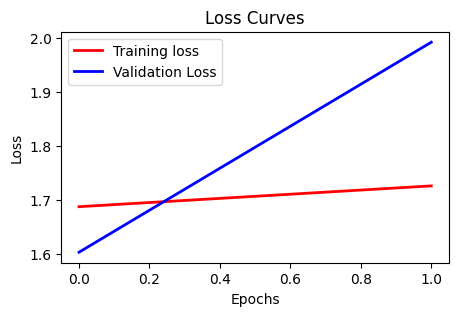

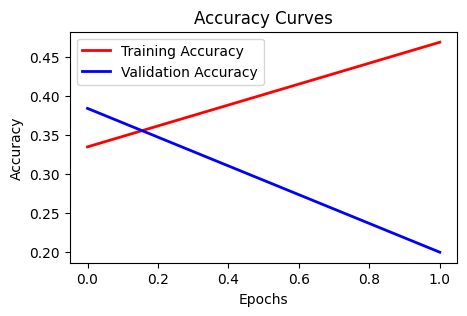

In [37]:
def plot_training_history(history):
    # 1. 손실 함수 그래프
    plt.figure(figsize=(5, 3))
    plt.plot(history.history['loss'], 'r', linewidth=2.0)
    plt.plot(history.history['val_loss'], 'b', linewidth=2.0)
    plt.legend(['Training loss', 'Validation Loss'])
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss Curves')

    # 2. 정확도 그래프
    plt.figure(figsize=(5, 3))
    plt.plot(history.history['accuracy'], 'r', linewidth=2.0)
    plt.plot(history.history['val_accuracy'], 'b', linewidth=2.0)
    plt.legend(['Training Accuracy', 'Validation Accuracy'])
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Accuracy Curves')

    plt.show()

plot_training_history(fine_tune_history)

### 5. 모델 저장 및 호출

In [65]:
model.save('model.h5')

In [67]:
new_model = load_model('model.h5')

### 5. 예측

In [21]:
# 감정 라벨
emotion_labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

- 사진 예측

In [68]:
img = cv2.imread("img.jpg")
gray, detected_face = detect_face(img)

if detected_face is not None:
    extracted_face = extract_face_features(gray, detected_face)
    if extracted_face is not None:
        # 예시: 모델에 입력하기 전에 이미지를 3채널로 확장 (EfficientNet 입력 요구 사항)
        extracted_face = np.repeat(extracted_face, 3, axis=-1)  # 1채널을 3채널로 변환
        extracted_face = np.reshape(extracted_face, (1, 48, 48, 3))  # 모델 입력 형태로 변환

        # 예측 (모델은 이미 로드되어 있다고 가정)
        res = new_model.predict(extracted_face)
        result_num = np.argmax(res)
        print(f"표정 예측: {emotion_labels[result_num]}")
        for i, prob in enumerate(res[0]):
            print(f"Class {i} ({emotion_labels[i]}): {prob * 100:.2f}%")
    else:
        print("얼굴 추출에 실패했습니다.")
else:
    print("얼굴을 찾을 수 없습니다.")

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
표정 예측: Neutral
Class 0 (Angry): 11.66%
Class 1 (Disgust): 9.56%
Class 2 (Fear): 17.25%
Class 3 (Happy): 8.63%
Class 4 (Sad): 12.50%
Class 5 (Surprise): 17.52%
Class 6 (Neutral): 22.88%


- 영상 예측(0.5초에 한번씩 캡쳐해서 이미지로 예측)

In [69]:
def process_video(video_path, model):
    emotion_labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

    # 영상 파일 열기
    video_capture = cv2.VideoCapture(video_path)

    # 영상의 FPS 확인
    fps = video_capture.get(cv2.CAP_PROP_FPS)  # 초당 프레임 수
    frame_interval = int(fps / 2)  # 0.5초 기준 프레임 간격 계산

    # 현재 시간
    frame_count = 0  # 프레임을 카운트하는 변수

    while True:
        # 영상에서 프레임 읽기
        ret, frame = video_capture.read()

        # 프레임이 제대로 읽어졌는지 확인
        if not ret:
            print("영상에서 프레임을 읽을 수 없습니다.")
            break

        # 지정한 간격마다 프레임 처리
        if frame_count % frame_interval == 0:
            # 얼굴 감지 및 특징 추출
            gray, detected_face = detect_face(frame)

            # 초 계산
            current_time_sec = frame_count / fps

            if detected_face is not None:
                # 얼굴 특징 추출
                extracted_face = extract_face_features(gray, detected_face)
                if extracted_face is not None:
                    # 1채널 이미지를 3채널로 확장
                    extracted_face = np.repeat(extracted_face, 3, axis=-1)
                    extracted_face = np.reshape(extracted_face, (1, 48, 48, 3))  # 모델 입력 형태로 변환

                    # 예측 (모델은 이미 로드되어 있다고 가정)
                    res = model.predict(extracted_face)
                    result_num = np.argmax(res)
                    print(f"[{current_time_sec:.2f}초] 표정 예측: {emotion_labels[result_num]}")

                    # 각 클래스에 대한 확률을 출력
                    for i, prob in enumerate(res[0]):
                        print(f"Class {i} ({emotion_labels[i]}): {prob * 100:.2f}%")
                else:
                    print("얼굴 추출에 실패했습니다.")
            else:
                print("얼굴을 찾을 수 없습니다.")

        # 프레임 카운트 증가
        frame_count += 1

    # 모든 작업 완료 후 캡처 리소스 해제
    video_capture.release()
    cv2.destroyAllWindows()


process_video('video.mp4', new_model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
[0.00초] 표정 예측: Neutral
Class 0 (Angry): 11.66%
Class 1 (Disgust): 9.56%
Class 2 (Fear): 17.25%
Class 3 (Happy): 8.62%
Class 4 (Sad): 12.50%
Class 5 (Surprise): 17.54%
Class 6 (Neutral): 22.87%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
[0.50초] 표정 예측: Neutral
Class 0 (Angry): 11.66%
Class 1 (Disgust): 9.55%
Class 2 (Fear): 17.25%
Class 3 (Happy): 8.62%
Class 4 (Sad): 12.50%
Class 5 (Surprise): 17.54%
Class 6 (Neutral): 22.87%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
[1.00초] 표정 예측: Neutral
Class 0 (Angry): 11.66%
Class 1 (Disgust): 9.55%
Class 2 (Fear): 17.25%
Class 3 (Happy): 8.62%
Class 4 (Sad): 12.51%
Class 5 (Surprise): 17.54%
Class 6 (Neutral): 22.87%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
[1.50초] 표정 예측: Neutral
Class 0 (Angry): 11.66%
Class 1 (Disgust): 9.55%
Class 2 (Fear): 17.25%
Class 3 (Happy): 8.62%
Class 4 (Sad): 12.51%
Class 5 (Surprise): 17.54%
Class 6 (Neutral): 22.87%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
[2.00초] 표정 예측: Neutral
Class 0 (Angry)